In [2]:
# HW 2a
from __future__ import print_function
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# set the dimension
n  = 10; r0 = 60; D = 150;
n_input=500; m=50 # n_input = 500 so that there are 10 mini-batches

class Dataset():
    def __init__(self, n, r0, D):
        # create U, V optimum from n, r0, D
        self.D    = D
        self.U    = torch.normal(mean=torch.zeros([n,r0]), std=torch.ones([n,r0])/np.sqrt(r0))
        self.V_T  = torch.normal(mean=torch.zeros([r0, D]), std=torch.ones([D,r0])/np.sqrt(D))
            ## `torch.normal(mean = tensor1, std = tensor1)`, same size
    def generate_samples(self, n_input, m):
        # create x, y from U,V optimum
        x  = torch.randn(self.D, n_input)
        y  = torch.mm(self.U, F.relu(torch.mm(self.V_T,x))) 
            ## `torch.mm(tensor1_matrix, tensor2_matrix)`: matrix multiplication
            ## `_F.relu(tensor)`: element-wise ReLU activation
        
        samples_pre = data.TensorDataset(x.T,y.T)
            ## `_data.TensorDataset(*tensors)`: data wrapping tensors with same 1st dimension
            ### __getitem__: return {Set | Set_i =turple(tensor_x[i] ~D,tensor_y[i] ~ r0), i in range #row x,y
            ### __len__: return self.tensors[0].size(0) # of 1st dim/row in x
        samples = data.DataLoader(samples_pre, batch_size=m, shuffle=True,num_workers=3)
            ## `data.DataLoader()` shuffle x,y into batch
            ### from x.T(500x150) -> ten batch_x.T(50x150), y.T(500x10) -> ten batch_y(50x10)
        return samples
dataset = Dataset(n, r0, D)  # generate U, V_T optimum
ds = dataset.generate_samples(n_input, m) # 
print('HW 2a')
for step, (batch_x, batch_y) in enumerate(ds):
    l2 = torch.mean(batch_y ** 2)
    print('batch #', step, ' : L2 norm ', l2.item())



HW 2a
batch # 0  : L2 norm  0.5830911993980408
batch # 1  : L2 norm  0.598063588142395
batch # 2  : L2 norm  0.5924168229103088
batch # 3  : L2 norm  0.619966447353363
batch # 4  : L2 norm  0.6507449150085449
batch # 5  : L2 norm  0.5360133051872253
batch # 6  : L2 norm  0.5668997764587402
batch # 7  : L2 norm  0.6252177357673645
batch # 8  : L2 norm  0.6155403256416321
batch # 9  : L2 norm  0.6032831072807312


In [3]:
#HW 2b
class Net(nn.Module): 
    def __init__(self, D, r, n):
        super(Net, self).__init__()
        self.V_T = nn.Linear(D, r, bias=False) # bias = False -> y= Ax, # bias = True -> y= Ax+b 
        self.U = nn.Linear(r, n, bias=False)
    def forward(self, x):
        y = self.U(F.relu(self.V_T(x)))
        return y # predicted y

def train(model, ds, epochs, lr, decay_rate=0.5, decay_step=50):
    # weight_decay = decrease learning rate = 1/2, every 50 epochs
    # lr = initial learning rate
    optimizer = optim.SGD(model.parameters(), lr=lr)  # ~ updating U V
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_rate) # ~ update step size
    criterion = nn.MSELoss()  # square L2 norm
    
    model.train()
    for epoch in range(epochs):
        losses = []
        for step, (batch_x, batch_y) in enumerate(ds):
            optimizer.zero_grad()
            predict_y = model(batch_x)
            loss = 0.5 * criterion(predict_y, batch_y)  # calculate loss function = 1/2 *L_2^2
            losses.append(loss.item())
            loss.backward()  # use loss function in 'optimizer'
            optimizer.step() # update U, V_T
            
        scheduler.step() # update step size each epochs
        print( 'epoch: ',epoch, ", loss:", np.mean(np.array(losses)))
        
model = Net(D, r0, n)
ds = dataset.generate_samples(n_input=10000, m=50)
print("HW 2b")
train(model, ds, epochs=100, lr=0.01) # try 100 epoch

HW 2b
epoch:  0 , loss: 0.24875651277601718
epoch:  1 , loss: 0.19361904814839362
epoch:  2 , loss: 0.17442983612418175
epoch:  3 , loss: 0.16481267981231212
epoch:  4 , loss: 0.15798883780837059
epoch:  5 , loss: 0.15220399178564548
epoch:  6 , loss: 0.14696343079209329
epoch:  7 , loss: 0.14210246790200473
epoch:  8 , loss: 0.1375455652177334
epoch:  9 , loss: 0.13324234664440154
epoch:  10 , loss: 0.12915793500840664
epoch:  11 , loss: 0.12525852154940367
epoch:  12 , loss: 0.12152826953679323
epoch:  13 , loss: 0.11795440215617418
epoch:  14 , loss: 0.11452391676604748
epoch:  15 , loss: 0.11122560061514378
epoch:  16 , loss: 0.1080492739751935
epoch:  17 , loss: 0.10499215185642242
epoch:  18 , loss: 0.1020548825711012
epoch:  19 , loss: 0.09923289224505424
epoch:  20 , loss: 0.0965223378315568
epoch:  21 , loss: 0.0939265539124608
epoch:  22 , loss: 0.09144152320921421
epoch:  23 , loss: 0.08906767304986715
epoch:  24 , loss: 0.08680458340793848
epoch:  25 , loss: 0.0846533387899

HW 2c


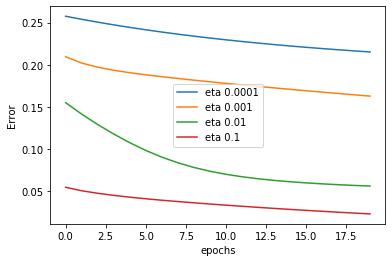

In [8]:
# Hw 2c
r =120
r0=60
dataset=Dataset(n=10, r0=r0, D=150) 
ds = dataset.generate_samples(n_input=10000, m=20) # using dataset (U,V optimum) to generate x,y
model = Net(D=150, r=r, n=10) # model U,V

eta = np.array([0.0001,0.001,0.01,0.1]) # learning rate
epochs =20
decay_rate = 0.5
decay_step = 50
    
fig = plt.figure()
ax = plt.axes()
plotx = np.linspace(0,epochs-1,epochs)
ax.set_xlabel('epochs')
ax.set_ylabel('Error')

print('HW 2c')
for i,lr in enumerate(eta):
    optimizer = optim.SGD(model.parameters(), lr=lr)  # ~ updating U V
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_rate) # ~ update step size
    criterion = nn.MSELoss()  # square L2 norm 
    model.train()
    ploty=[]
    for epoch in range(epochs):
        losses = []
        for step, (batch_x, batch_y) in enumerate(ds):
            optimizer.zero_grad()
            predict_y = model(batch_x)
            loss = 0.5 * criterion(predict_y, batch_y)  # calculate loss function = 1/2 *L_2^2
            losses.append(loss.item())
            loss.backward()  # use loss function in 'optimizer'
            optimizer.step() # update U, V_T
        scheduler.step() # update step size each epochs
        E_loss= np.mean(np.array(losses)) # Expected loss
        ploty= np.append(ploty,E_loss)
    ax.plot(plotx,ploty, label='eta '+str(lr))
ax.legend();
plt.show()

HW 2d


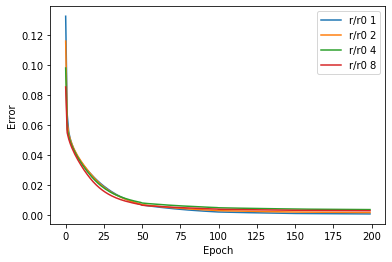

In [9]:
# Hw 2d

r0= 60
r_r0=np.array([1,2,4,8])
r= r_r0*r
lr = 0.1 # best one
epochs =200
decay_rate = 0.5
decay_step = 50
    
fig = plt.figure()
ax = plt.axes()
plotx = np.linspace(0,epochs-1,epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')

print('HW 2d')

for i,r_i in enumerate(r):
    model = Net(D=150, r=r_i, n=10) 
    optimizer = optim.SGD(model.parameters(), lr=lr)  # ~ updating U V
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_rate) # ~ update step size
    criterion = nn.MSELoss()  # square L2 norm 
    model.train()
    ploty=[]
    for epoch in range(epochs):
        losses = []
        for step, (batch_x, batch_y) in enumerate(ds):
            optimizer.zero_grad()
            predict_y = model(batch_x)
            loss = 0.5 * criterion(predict_y, batch_y)  # calculate loss function = 1/2 *L_2^2
            losses.append(loss.item())
            loss.backward()  # use loss function in 'optimizer'
            optimizer.step() # update U, V_T
        scheduler.step() # update step size each epochs
        E_loss= np.mean(np.array(losses)) # Expected loss
        ploty= np.append(ploty,E_loss)
    ax.plot(plotx,ploty, label='r/r0 '+str(r_r0[i]))
ax.legend();
plt.show()

In [11]:
# Hw 2e

# The result from (2d) is satifying. Every setup 'r/r0' eventually has the error 
# clos to 0. We notice that in Epoch around 0-25 that r/r0 has the smallest error.
# This result agrees with the theory that the over-parameterization levels will 
# overfit the training set. 



SyntaxError: ignored